In [1]:
import ast
from pathlib import Path
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.notebook import trange

from kgi import apply_kgi_to_model

In [2]:
# attempt to enable LaTeX rendering
# change to `False` if you get an error during plotting (latex not installed)
plt.rcParams['text.usetex'] = True

In [3]:
def default_init_to_he_uniform(model):
    """ Change PyTorch's default initialization to He uniform """
    # PyTorch default uses 1/sqrt(m) as the bound
    # He uniform uses sqrt(3)/sqrt(m) as the bound
    sqrt3 = np.sqrt(3)
    for layer in model.modules():
        if isinstance(layer, torch.nn.Linear):
            layer.weight.data *= sqrt3
            layer.bias.data *= sqrt3


class MLP(nn.Module):
    """ MLP model """

    def __init__(self, input_size, hidden_size, num_hidden_layers=1, activation=torch.relu):
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)]
        )
        self.output_layer = nn.Linear(hidden_size, 3)
        self.act = activation
        default_init_to_he_uniform(self)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.act(x)
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.act(x)
        x = self.output_layer(x)
        return x

# Data

In [4]:
def extract_values_from_string(input_str):
    """ df.Composition stores strings; parse to numbers """
    input_list = ast.literal_eval(input_str)
    elements = ['Ag', 'Al', 'Au']
    row_values = {element: 0.0 for element in elements}
    for item in input_list:
        element, value = item.split(':')
        row_values[element.strip()] = float(value.strip())
    return [row_values[element] for element in elements]

In [5]:
# truncate tail
truncate = 2000
# decimate data
decimate = 2

df = pd.read_pickle('datasets/muons.pkl')
# read data
x_in = df.Spectra
x_list = [a for a in x_in]
x_arr = np.array(x_list)[:, :truncate:decimate]
# normalize data
min_vals = np.min(x_arr, axis=1, keepdims=True)
max_vals = np.max(x_arr, axis=1, keepdims=True)
x_arr = (x_arr - min_vals) / (max_vals - min_vals)
# read labels
y_arr = []
for comp in df.Composition:
    y_arr.append(extract_values_from_string(comp))
y_arr = np.array(y_arr)
print("Data", x_arr.shape)
print("Labels", y_arr.shape)

Data (10000, 1000)
Labels (10000, 3)


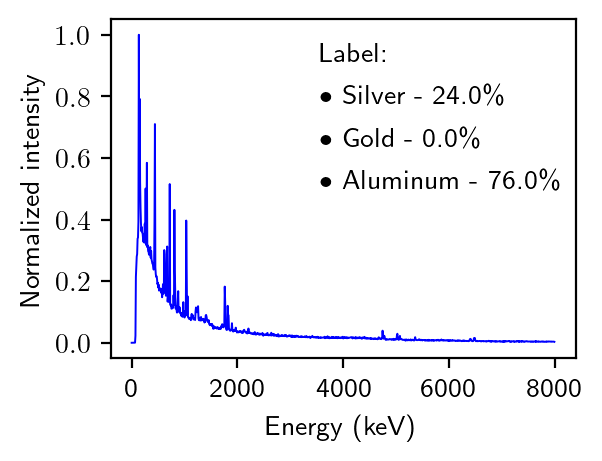

In [6]:
plt.figure(dpi=200, figsize=(3, 2.2))
index = 19
plt.plot(x_arr[index], c='b', lw=.7)
plt.xticks(np.arange(0, 1001, 250), np.arange(0, 1001, 250) * 8)
plt.text(.45, 7 / 8, "Label:", ha="left", transform=plt.gca().transAxes)
plt.text(.45, 6 / 8, f"\u2022 Silver - {y_arr[index][0] * 100}\%", ha="left", transform=plt.gca().transAxes)
plt.text(.45, 5 / 8, f"\u2022 Gold - {y_arr[index][1] * 100}\%", ha="left", transform=plt.gca().transAxes)
plt.text(.45, 4 / 8, f"\u2022 Aluminum - {y_arr[index][2] * 100}\%", ha="left", transform=plt.gca().transAxes)
plt.xlabel("Energy (keV)")
plt.ylabel("Normalized intensity")
plt.savefig("figs/muons_data.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()

# Training

In [7]:
train_lim = 6000
device = "cpu"
x_train = torch.from_numpy(x_arr[:train_lim]).to(device)
y_train = torch.from_numpy(y_arr[:train_lim]).float().to(device)
x_test = torch.from_numpy(x_arr[train_lim:]).to(device)
y_test = torch.from_numpy(y_arr[train_lim:]).float().to(device)

In [8]:
def train(kgi, hidden_size, num_hidden_layers, seed, activation=torch.relu,
          num_epochs=1000, log_loss_every=1, pbar=True, bin_threshold=0.01):
    """ Train a model """
    torch.manual_seed(seed)
    model = MLP(x_train.size(1), hidden_size=hidden_size, num_hidden_layers=num_hidden_layers,
                activation=activation)
    if kgi:
        if activation is torch.nn.functional.tanh:
            apply_kgi_to_model(model,
                               knot_low=[0.2] + [-0.8] * (num_hidden_layers + 1),
                               knot_high=[0.8] * (num_hidden_layers + 2),
                               perturb_factor=0.2, kgi_by_bias=False)
        else:
            apply_kgi_to_model(model, knot_low=0., knot_high=1.,
                               perturb_factor=0.2, kgi_by_bias=False)
    model.to(device)
    model.train()
    criterion = nn.KLDivLoss(reduction="batchmean")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # training loop
    loss_hist = []
    batch_size = 512
    for epoch in trange(num_epochs, disable=not pbar):
        # shuffle data
        perm = torch.randperm(x_train.size(0))
        x_train_perm = x_train[perm]
        y_train_perm = y_train[perm]
        epoch_loss = 0.
        for i in range(0, x_train.size(0), batch_size):
            x_batch = x_train_perm[i:i + batch_size]
            y_batch = y_train_perm[i:i + batch_size]
            y_pred = model(x_batch)
            y_pred = torch.log_softmax(y_pred, dim=-1)
            loss = criterion(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(range(0, x_train.size(0), batch_size))
        if (epoch + 1) % log_loss_every == 0:
            loss_hist.append(epoch_loss)

    # evaluation
    model.eval()
    with torch.no_grad():
        y_pred_all = model(x_test)
        y_pred_all = torch.softmax(y_pred_all, dim=-1)
        cosine_similarity = torch.einsum("ik,ik->i", y_pred_all, y_test).mean()
        diff = torch.abs(y_pred_all - y_test)
        success_per_sample = torch.all(diff < bin_threshold, dim=1)  # noqa
        bin_accuracy = success_per_sample.float().mean()
    return model, loss_hist, cosine_similarity, bin_accuracy

In [9]:
seeds = list(range(10))  # use `seeds = [0]` for fast test
epochs = 5000  # use a smaller one for fast test
out_dir = Path("results/muons_paper")
act_ = torch.nn.functional.relu
hidden_size_ = 128
num_hidden_layers_ = 2

out_dir.mkdir(exist_ok=True, parents=True)
for seed_ in seeds:
    for kgi_ in [False, True]:
        name_ = f"{seed_}_{kgi_}"
        if not (out_dir / name_).exists():
            t0 = time()
            _, hist_, cos_sim, bin_acc = train(kgi_, hidden_size_, num_hidden_layers_, seed_, act_,
                                               num_epochs=epochs, log_loss_every=1, pbar=False)
            np.savetxt(out_dir / name_, hist_, header=f"{cos_sim} {bin_acc}")
            print(f"{name_} trained in {(time() - t0) / 60:.1f} min, loss={hist_[-1]:.2e}")
        else:
            print(f"{name_} exists")

0_False exists
0_True exists
1_False exists
1_True exists
2_False exists
2_True exists
3_False exists
3_True exists
4_False exists
4_True exists
5_False exists
5_True exists
6_False exists
6_True exists
7_False exists
7_True exists
8_False exists
8_True exists
9_False exists
9_True exists


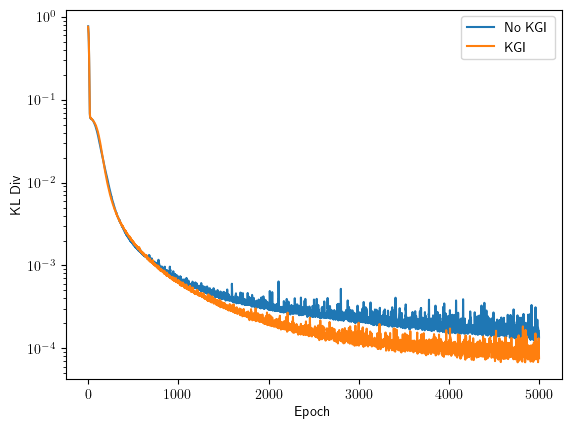

In [10]:
# quick plot
hist_no_kgi = np.loadtxt('results/muons_paper/0_False')
hist_kgi = np.loadtxt('results/muons_paper/0_True')
plt.plot(hist_no_kgi[:5000], label='No KGI')
plt.plot(hist_kgi[:5000], label='KGI')
plt.yscale("log")
plt.legend()
plt.ylabel('KL Div')
plt.xlabel('Epoch')
plt.show()

# Analysis

In [11]:
def print_metrics(kgi):
    losses = []
    slowness = []
    metrics = []
    for seed in seeds:
        # read history
        name = f"{seed}_{kgi}"
        hist = np.loadtxt(out_dir / name)
        # use average of last 10 epochs
        final_loss = hist[-10:].mean()
        losses.append(final_loss)
        # AUC for convergence slowness
        init_loss = hist[:10].mean()
        slowness.append(hist.mean() / init_loss)
        # read relative error
        with open(out_dir / name) as fs:
            err_str = fs.readline()
        err = float(err_str.split(" ")[2])
        metrics.append(err)
    losses = np.array(losses) * 10000
    slowness = np.array(slowness) * 100
    metrics = np.array(metrics) * 100
    # excluding top-k losses
    idx = np.argsort(losses)[:-3]
    losses = losses[idx]
    slowness = slowness[idx]
    metrics = metrics[idx]
    print("KGI" if kgi else "No KGI")
    # print in latex format
    print("\nKGI" if kgi else "\nNo KGI")
    print(f"Loss: {losses.mean():.2f} ± {losses.mean():.2f}")
    print(f"slowness: {slowness.mean():.2f} ± {slowness.std():.2f}")
    print(f"Acc: {metrics.mean():.1f} ± {metrics.std():.1f}%")
    return losses.mean(), losses.std(), slowness.mean(), slowness.std(), metrics.mean(), metrics.std()


lmf, lsf, smf, ssf, amf, asf = print_metrics(False)
lmt, lst, smt, sst, amt, ast = print_metrics(True)
lmf, lsf, lmt, lst = lmf, lsf, lmt, lst
print("\nCopy to table")
print(f"$\mu$SR & "
      f"${lmf:.2f}\!\pm\!{lsf:.2f}$ & ${lmt:.2f}\!\pm\!{lst:.2f}$ & "
      f"${smf:.2f}\!\pm\!{ssf:.2f}$ & ${smt:.2f}\!\pm\!{sst:.2f}$ & Acc. & "
      f"${amf:.2f}\!\pm\!{asf:.2f}\%$ & ${amt:.2f}\!\pm\!{ast:.2f}\%$")

No KGI

No KGI
Loss: 1.26 ± 1.26
slowness: 0.63 ± 0.05
Acc: 88.5 ± 3.7%
KGI

KGI
Loss: 0.88 ± 0.88
slowness: 0.59 ± 0.04
Acc: 90.1 ± 4.2%

Copy to table
$\mu$SR & $1.26\!\pm\!0.33$ & $0.88\!\pm\!0.30$ & $0.63\!\pm\!0.05$ & $0.59\!\pm\!0.04$ & Acc. & $88.51\!\pm\!3.66\%$ & $90.06\!\pm\!4.16\%$
